In [3]:
pip install pandas matplotlib seaborn mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                             user = "root",
                             password = "Shivam1234",
                             database = "ecommerce")

cur = db.cursor()
                                                         

# List all unique cities where customers are located.

In [65]:
query = """ select distinct(customer_city) from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the number of orders placed in 2017.

In [17]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are",data[0][0] 

('total orders placed in 2017 are', 45101)

 # Find the total sales per category.

In [31]:
query = """ select upper(products.product_category_name) category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMARIA,506738.66
1,MOVEIS_DECORACAO,1430176.39
2,TELEFONIA,486882.05
3,FASHION_BOLSAS_E_ACESSORIOS,218158.28
4,CAMA_MESA_BANHO,1712553.67
...,...,...
69,CDS_DVDS_MUSICAIS,1199.43
70,LA_CUISINE,2913.53
71,FASHION_ROUPA_INFANTO_JUVENIL,785.67
72,PC_GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.

In [48]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*)*100 from payments """

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

In [42]:
# OR

In [50]:
query = """ select (sum(case when payment_installments > 1 then 1 else 0 end))/count(*)*100 from payments """

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('49.4176'))

# Count the number of customers from each state. 

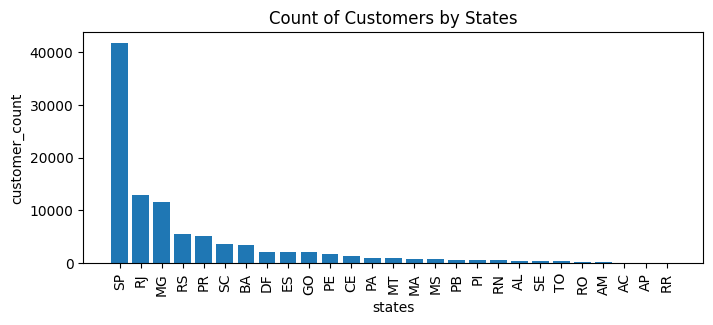

In [90]:
query = """ select customer_state ,count(customer_id) from customers group by customer_state """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

# Calculate the number of orders per month in 2018.

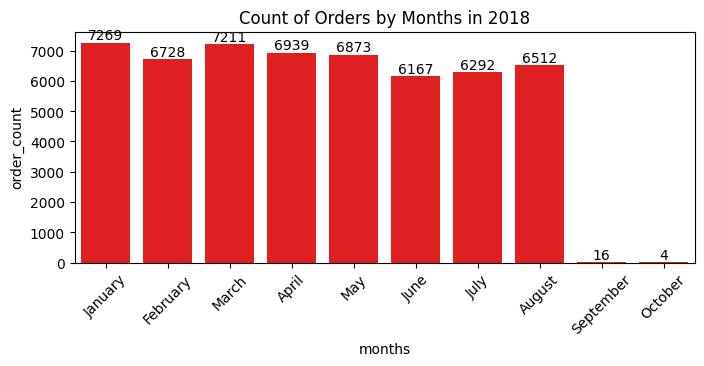

In [112]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) 
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January","February","March","April","May","June", "July","August","September","October"]

plt.figure(figsize = (8,3))
ax = sns.barplot(x = df["months"],y = df["order_count"], data = df, order = o, color = "red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months in 2018")

plt.show()

#  Find the average number of products per order, grouped by customer city.

In [130]:
query = """ with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["customer_city", "average products per order"])
df

,customer_city,average products per order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
...,...,...
4105,lagoa da canoa,1.00
4106,japaratuba,1.00
4107,sebastiao leal,1.00
4108,morro agudo de goias,1.00


# Calculate the percentage of total revenue contributed by each product category.

In [25]:
query = """select upper(products.product_category_name) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100, 2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc;
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "percentage distribution"])
df

,Category,percentage distribution
0,CAMA_MESA_BANHO,10.70
1,BELEZA_SAUDE,10.35
2,INFORMATICA_ACESSORIOS,9.90
3,MOVEIS_DECORACAO,8.93
4,RELOGIOS_PRESENTES,8.93
...,...,...
69,CASA_CONFORTO_2,0.01
70,CDS_DVDS_MUSICAIS,0.01
71,PC_GAMER,0.01
72,FASHION_ROUPA_INFANTO_JUVENIL,0.00


# Identify the correlation between product price and the number of times a product has been purchased.

In [34]:
query = """select products.product_category_name,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category_name"""


cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "order_count", "price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is:", a[0][1])

the correlation between price and number of times a product has been purchased is: -0.10631514167157562


 # Calculate the total revenue generated by each seller, and rank them by revenue.

In [47]:
query = """select *, dense_rank() over(order by revenue desc) as rn from 
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a 
"""


cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df


,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.209999,3082
3091,702835e4b785b67a084280efca355756,18.559999,3083
3092,4965a7002cca77301c82d3f91b82e1a9,16.360001,3084
3093,77128dec4bec4878c37ab7d6169d6f26,15.220000,3085


In [ ]:
# OR

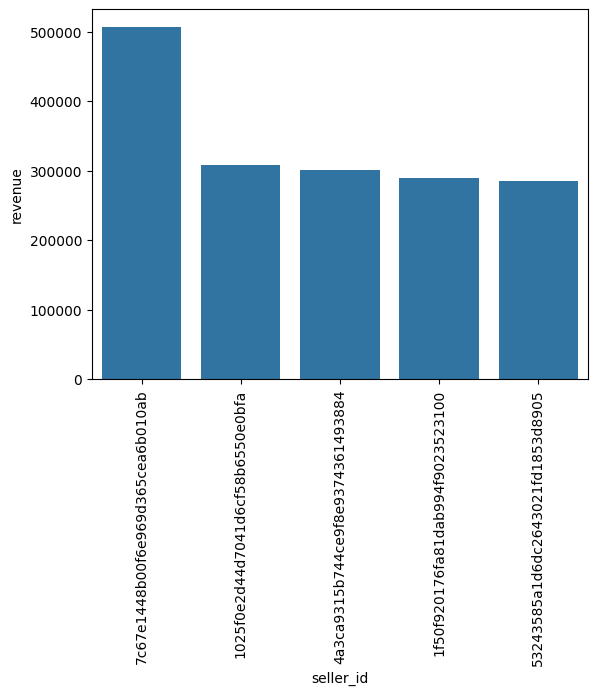

In [55]:
query = """select *, dense_rank() over(order by revenue desc) as rn from 
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a 
"""


cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [8]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a """


cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["customer_id", "order_purchase_timestamp", "price", "moving average"])
df





,customer_id,order_purchase_timestamp,price,moving average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year.

In [11]:
query = """select years, months, payment, sum(payment)
over(order by years, months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a """

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["years", "months", "payment", "Cumulative_sales"])
df


,years,months,payment,Cumulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year-over-year growth rate of total sales.

In [20]:
 query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)
select years, ((payment - lag(payment, 1) over(order by years)) / lag(payment, 1) over(order by years)) * 100
from a """

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df
 ## (formula of) year over year ((yoy % growth))= [(current sales - previous_year sales)/previous_year sales] multiplied by 100 to get a percentage.

,years,yoy % growth
0,2016,NaN
1,2017,12112.703795
2,2018,20.000923


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [31]:
query = """ with a as(select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id) ,

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) necxt_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order 
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month) 
group by a.customer_id) 

select 100 * (count(distinct a.customer_id)/ count(distinct b.customer_id))
from a left join b 
on a.customer_id = b.customer_id ; """

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

<function matplotlib.pyplot.show(close=None, block=None)>

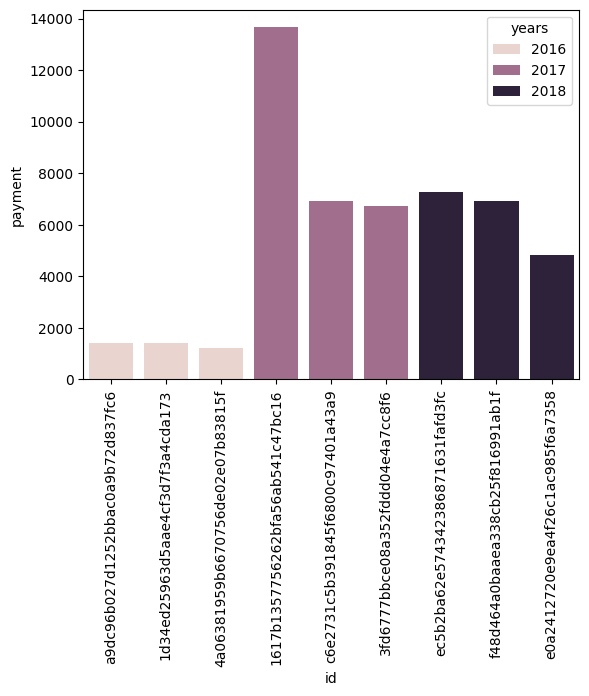

In [48]:
query = """ select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years, 
orders.customer_id,
sum(payments.payment_value) payment, 
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ; """

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["years", "id", "payment", "rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show

                  

# CHATGPTs QUERIES

# 1. What are the unique product categories available?

In [16]:
query = """ select distinct(product_category_name) as product_categories from products;"""
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["product_categories"])
df
df.head()

,product_categories
0,perfumaria
1,artes
2,esporte_lazer
3,bebes
4,utilidades_domesticas


# 2. How many sellers are there in the dataset?

In [18]:
query = """ select count(distinct(seller_id)) as total_sellers from sellers """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["total_sellers"])
df
df.head()

,total_sellers
0,3095


# 3. Find the number of orders per payment type.

In [21]:
query = """ select count(order_id), payment_type from payments
group by payment_type
"""
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["order_id","payment_type"])
df

,order_id,payment_type
0,76795,credit_card
1,19784,boleto
2,5775,voucher
3,1529,debit_card
4,3,not_defined


<function matplotlib.pyplot.show(close=None, block=None)>

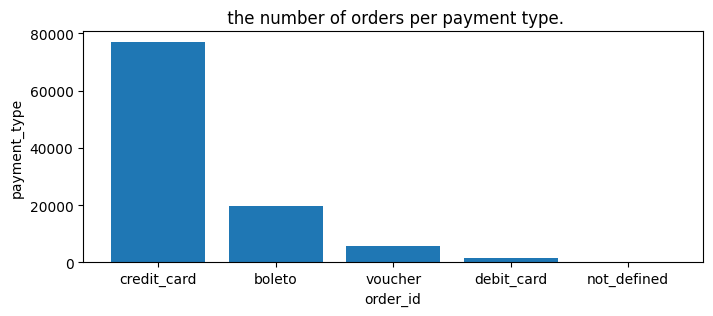

In [23]:
df = pd.DataFrame(data, columns = ["order_id","payment_type"])
df = df.sort_values(by = "order_id", ascending = False)
df
plt.figure(figsize = (8,3))
plt.bar(df["payment_type"], df["order_id"])
plt.xlabel("order_id")
plt.ylabel("payment_type")
plt.title(" the number of orders per payment type.")
plt.xticks(rotation = 0)
plt.show 

# 4. List the top 10 cities with the highest number of orders.

In [28]:
query = """ select customers.customer_city as cities, count(orders.order_id) as total_orders
from customers join orders
on customers.customer_id = orders.customer_id
group by cities
order by total_orders desc
limit 10;
; """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["cities","total_orders"])
df

,cities,total_orders
0,sao paulo,15540
1,rio de janeiro,6882
2,belo horizonte,2773
3,brasilia,2131
4,curitiba,1521
5,campinas,1444
6,porto alegre,1379
7,salvador,1245
8,guarulhos,1189
9,sao bernardo do campo,938


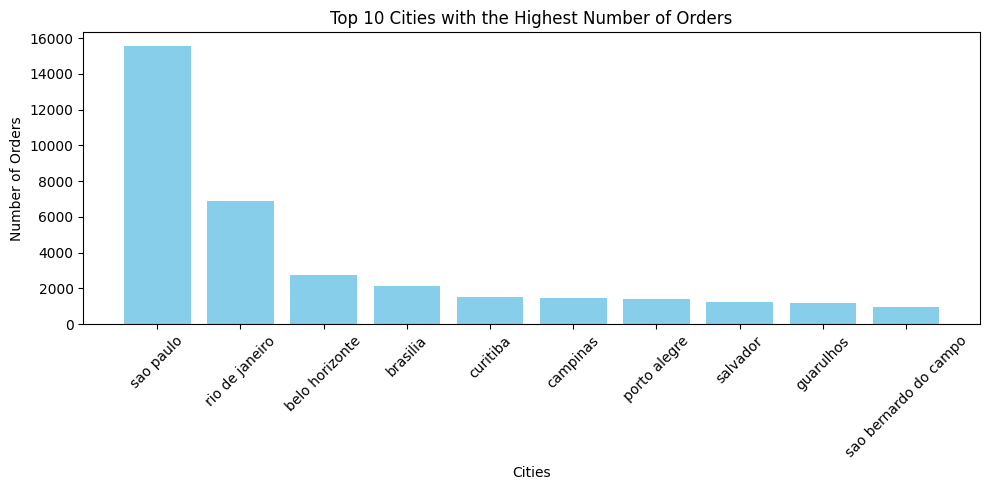

In [34]:
import matplotlib.pyplot as plt

# Sort DataFrame to ensure it's ordered (if not already)
df = df.sort_values(by="total_orders", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(df["cities"], df["total_orders"], color="skyblue")
plt.xlabel("Cities")
plt.ylabel("Number of Orders")
plt.title("Top 10 Cities with the Highest Number of Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

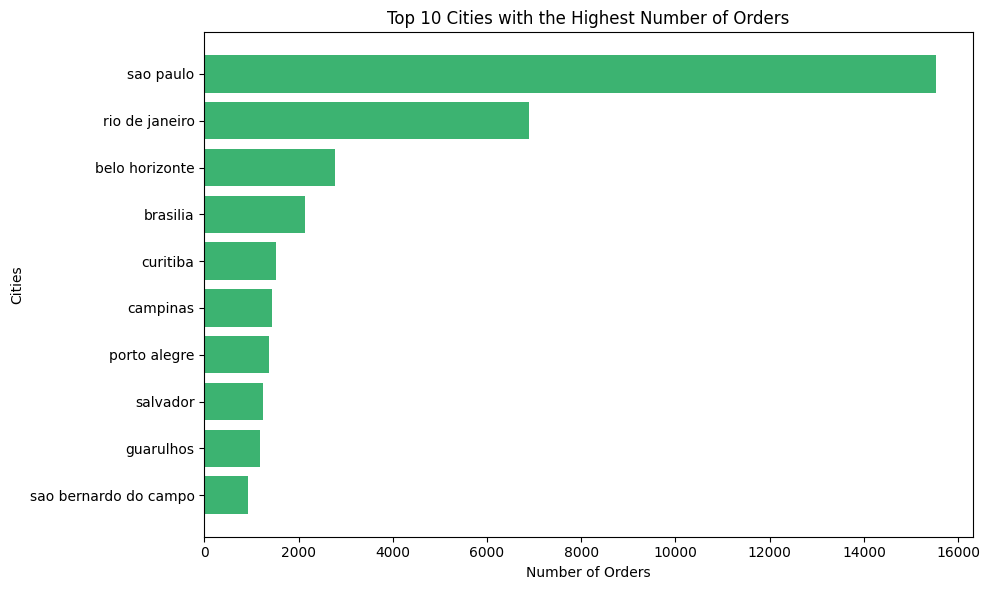

In [36]:
plt.figure(figsize=(10, 6))
plt.barh(df["cities"], df["total_orders"], color="mediumseagreen")
plt.xlabel("Number of Orders")
plt.ylabel("Cities")
plt.title("Top 10 Cities with the Highest Number of Orders")
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()

# 5. Count the number of reviews with each rating (1 to 5)

In [39]:
query = """ select count(review_id), review_score
from order_reviews
group by review_score;

; """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["count of review_id","review_score"])
df

,count of review_id,review_score
0,19142,4
1,57328,5
2,11424,1
3,8179,3
4,3151,2


# 6. Find the earliest and latest order dates in the dataset.

In [42]:
query = """ select order_id, date(order_purchase_timestamp) as earliest
from orders
order by earliest
limit 1;
; """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["order_id","earliest_date_of_order"])
df

,order_id,earliest_date_of_order
0,2e7a8482f6fb09756ca50c10d7bfc047,2016-09-04


In [44]:
query = """ select order_id, date(order_purchase_timestamp) as latest
from orders
order by latest desc
limit 1;
; """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["order_id","latest_date_of_order"])
df

,order_id,latest_date_of_order
0,10a045cdf6a5650c21e9cfeb60384c16,2018-10-17


# 1. Calculate average delivery time (from order to delivered date)

In [19]:
query = """ SELECT ROUND(AVG(DATEDIFF(order_delivered_customer_date, order_purchase_timestamp)),2) AS avg_delivery_time_days
FROM ecommerce.orders
WHERE order_status = "delivered"
AND order_delivered_customer_date IS NOT NULL
AND order_purchase_timestamp IS NOT NULL;
 """
cur.execute(query)
data = cur.fetchall()
print(f"Average Delivery time: {float(data[0][0])} days")

Average Delivery time: 12.5 days


# 2. Find the average review score by product category

In [51]:
query = """ select products.product_category_name, avg(order_reviews.review_score) as avg_prod_review
from products join order_items
on products.product_id = order_items.product_id
join order_reviews
on order_reviews.order_id = order_items.order_id
group by product_category_name;
 """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["product_category_name","avg_prod_review"])
df

,product_category_name,avg_prod_review
0,relogios_presentes,4.0192
1,livros_tecnicos,4.3684
2,informatica_acessorios,3.9308
3,eletronicos,4.0375
4,esporte_lazer,4.1080
...,...,...
69,cds_dvds_musicais,4.6429
70,la_cuisine,4.0000
71,fashion_roupa_infanto_juvenil,4.5000
72,pc_gamer,3.3333


# 3. Analyze average payment value per order status.

In [54]:
query = """ select products.product_category_name as category, round(avg(payments.payment_value),2) as avg_payment
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by product_category_name
"""
cur.execute(query)
data = cur.fetchall()
data
# and if i want to dataframe
df = pd.DataFrame(data, columns = ["Catogory", "avg_payment"])
df

,Catogory,avg_payment
0,perfumaria,142.34
1,moveis_decoracao,163.56
2,telefonia,103.13
3,fashion_bolsas_e_acessorios,101.42
4,cama_mesa_banho,144.85
...,...,...
69,cds_dvds_musicais,85.67
70,la_cuisine,182.10
71,fashion_roupa_infanto_juvenil,98.21
72,pc_gamer,217.44


# 4. Analyze average payment value per order status.

In [37]:
query = """SELECT orders.order_status, ROUND(AVG(payments.payment_value),2) AS avg_payment_value
FROM ecommerce.orders
JOIN ecommerce.payments
ON orders.order_id = payments.order_id
GROUP BY orders.order_status
ORDER BY avg_payment_value DESC; """
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["order_status", "avg_payment_value"])
df

,order_status,avg_payment_value
0,processing,217.54
1,canceled,215.75
2,invoiced,212.73
3,unavailable,194.88
4,delivered,153.07
5,shipped,151.98
6,created,137.62
7,approved,120.54


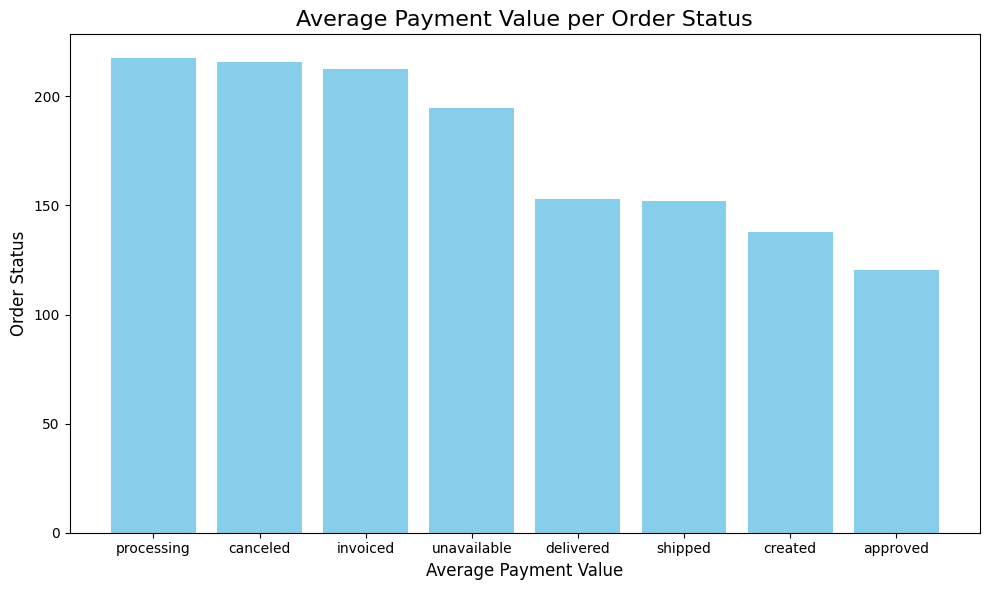

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(df["order_status"], df["avg_payment_value"], color = "skyblue") 
plt.title("Average Payment Value per Order Status", fontsize = 16)
plt.xlabel("Average Payment Value", fontsize = 12),
plt.ylabel("Order Status", fontsize = 12)
plt.tight_layout()
plt.show()

# 5. Identify the number of sellers with sales above a certain threshold

In [51]:
# Suppose my threshold is $ 10,000 in total sales:
query = """
SELECT COUNT(*) AS num_sellers_above_threshold
FROM (
   SELECT 
      order_items.seller_id, 
      SUM(order_items.price) AS total_sales
   FROM order_items
   JOIN orders ON order_items.order_id = orders.order_id
   WHERE orders.order_status = "delivered"
   GROUP BY order_items.seller_id 
   HAVING total_sales > 10000
) AS high_earning_sellers;
"""
cur.execute(query)
data = cur.fetchall()
print("Number of sellers above threshold : ", data[0][0])



Number of sellers above threshold :  282


###   1. Predict average delivery time per region using historical data.

In [39]:
query = """
SELECT 
    customers.customer_state AS region,
    ROUND(AVG(DATEDIFF(orders.order_delivered_customer_date, orders.order_purchase_timestamp)), 2) AS avg_delivery_time
FROM 
    orders 
JOIN 
    customers ON orders.customer_id = customers.customer_id
WHERE 
    orders.order_status = 'delivered'
    AND orders.order_delivered_customer_date IS NOT NULL
    AND orders.order_purchase_timestamp IS NOT NULL
GROUP BY 
    customers.customer_state
ORDER BY 
    avg_delivery_time DESC;
"""

cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns=['Region', 'Avg Delivery Time(in days)'])
df

,Region,Avg Delivery Time(in days)
0,RR,29.34
1,AP,27.18
2,AM,26.36
3,AL,24.50
4,PA,23.73
5,MA,21.51
6,SE,21.46
7,CE,21.20
8,AC,21.00
9,PB,20.39


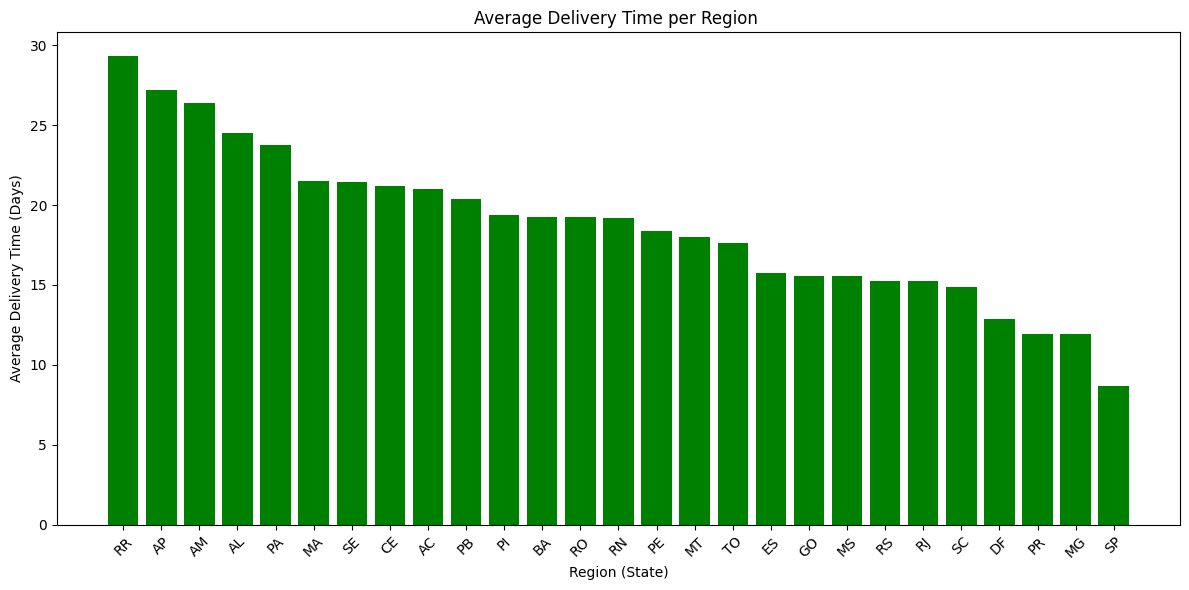

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(df['Region'], df['Avg Delivery Time(in days)'], color='green')
plt.xlabel('Region (State)')
plt.ylabel('Average Delivery Time (Days)')
plt.title('Average Delivery Time per Region ')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
###  2. Cluster customers based on total spending and number of orders.

In [61]:
###  3. Analyze refund or cancellation patterns (if status column allows).

# 4. Identify peak sales hours (if timestamp available).

In [18]:
query = """ SELECT
                EXTRACT(HOUR FROM order_purchase_timestamp) AS purchase_hour,
                COUNT(*) AS total_orders
            FROM orders
            GROUP BY purchase_hour
            ORDER BY total_orders DESC; """

cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns=['purchase_hour', 'total no. of orders'])
df
# Benifit: we can be able to know which time is better for selling.
        #  and we can plan marketing campaigns, dekivery schedule, customer services,etc according to this.

,purchase_hour,total no. of orders
0,16,6675
1,11,6578
2,14,6569
3,13,6518
4,15,6454
5,21,6217
6,20,6193
7,10,6177
8,17,6150
9,12,5995


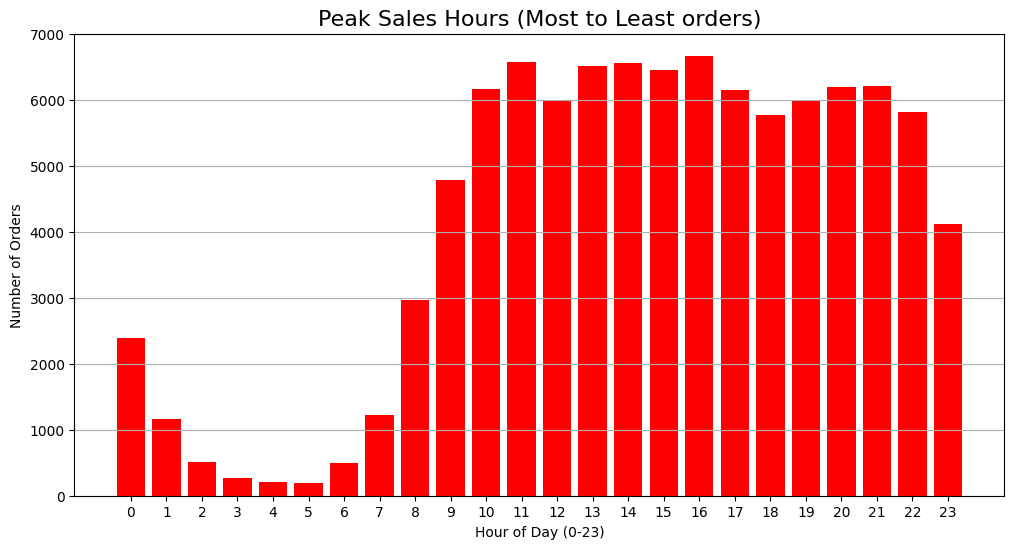

In [26]:
plt.figure(figsize = (12,6))
plt.bar(df['purchase_hour'],
df['total no. of orders'], color = 'red')
plt.title('Peak Sales Hours (Most to Least orders)', fontsize = 16)
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Orders')
plt.xticks(range(24)) # Ensure all 24 hours are shown.
plt.grid(axis = 'y')
plt.show()